In [1]:
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_distances
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import spatial

%matplotlib inline

try:
    code_dir
except NameError:
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/codes_local", "")
    salmon_dir = base_dir + "/0_salmon_DE_out/1_salmon_nonTrim"
    deseq2_dir = base_dir + "/0_salmon_DE_out/2_DEseq"
    deseq2_compile_dir = base_dir + "/0_salmon_DE_out/2_DEseq_compiled"
    root_dir = "/".join(base_dir.split("/")[:-1])
base_dir

'/media/pipkin/ROCKET-PRO/CD8_DEV_SC/5_Chd7_KO_RNA'

### 0. Preprocessing

In [3]:
tpm_file = deseq2_compile_dir + '/gene_tpm_bysample.csv'
tpm_df = pd.read_csv(tpm_file, index_col=0)

tpm_he_df = tpm_df[tpm_df.max(axis=1) > 20]
tpm_he_z_df = tpm_he_df.transpose().apply(zscore).transpose()
tpm_he_z_df_maxz = tpm_he_z_df.abs().max(axis=1)
tpm_he_hv_z_df = tpm_he_z_df[tpm_he_z_df_maxz > 1.5]
tpm_he_hv_z_df.shape

(5716, 24)

### 1. MDS

In [4]:
plot_out_dir = root_dir + '/9_Figures/5_Chd7_RNA_meta'

In [38]:
cos_dist_mtx = cosine_distances(tpm_he_hv_z_df.T, tpm_he_hv_z_df.T)
print(cos_dist_mtx.shape)

embedding = MDS(n_components=2, dissimilarity='precomputed', 
                random_state=0, max_iter=5000, n_init=10)
X_transformed = embedding.fit_transform(cos_dist_mtx)
mds_out_df = pd.DataFrame(X_transformed)
mds_out_df['types'] = tpm_df.columns.tolist()
mds_out_df['conds'] = ["_".join(x.split("_")[:-1]) for x in mds_out_df['types']]
mds_out_df['conds_simp'] = [x.split("_")[1] for x in mds_out_df['types']]
mds_out_df['conds_simp'] = pd.Categorical(mds_out_df['conds_simp'].tolist(), 
                                          categories=['Naive', '48h','EE', 'MP', 'DP', 'TE'])
mds_out_df['KO_WT'] = [x.split("_")[0] for x in mds_out_df['types']]

(24, 24)


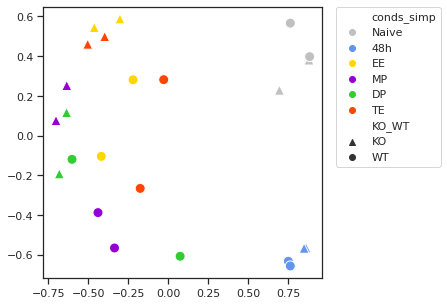

In [69]:
# conditions
outname = plot_out_dir + "/Chd7KO_conditions.png"

sns.set(rc={'figure.figsize':(5,5)}, style='ticks')
fig, ax = plt.subplots(1)
sns.scatterplot(data=mds_out_df, x=0, y=1, 
                style='KO_WT', markers = ['^','o'],
                hue='conds_simp', 
                palette=['silver','cornflowerblue', 'gold','darkviolet','limegreen','orangered'],
                linewidth=1, edgecolor='white',
                s=100, ax = ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()
fig.savefig(outname)

ax.get_legend().remove()
fig.savefig(outname.replace(".png", '_no_leg.png'))

### 2. Sample cosine similarity heatmap

In [25]:
conds = ['Naive','48h','EE','DP','MP','TE']
ordered_sps = []
for i in conds:
    ordered_sps += ["WT_%s_1"%i,"WT_%s_2"%i,"KO_%s_1"%i,"KO_%s_2"%i]

In [26]:
dist_df = pd.DataFrame(cos_dist_mtx)
dist_df.columns = tpm_he_hv_z_df.columns
dist_df.index = tpm_he_hv_z_df.columns
dist_df = dist_df[ordered_sps]
dist_df = dist_df.loc[ordered_sps]

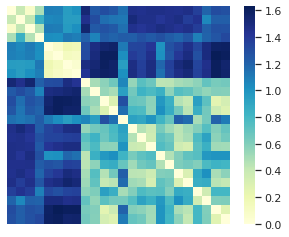

In [34]:
outname = plot_out_dir + "/Chd7KO_cosine_distance_heatmap.png"
sns.set(rc={'figure.figsize':(5,4)})

hm = sns.heatmap(dist_df, cmap="YlGnBu")

hm.set(xticklabels=[])
hm.set(yticklabels=[])

plt.savefig(outname)